# Human Distribution Analysis

Author: Xiaoyang Song & Morris Hsieh

## 1. Get Answer distribution of GPT3
* Get the logs from `checkpoint/MPI-results/Open-Vocab/order-symmetry/text-davinci-002`

In [1]:
OCEAN = 'OCEAN'
GPT_ANSWER_TRAIT = {} # Key: OCEAN, Value (cnt): [<1>, <2>, <3>, <4>, <5>]

# Read GPT Answer File
with open(
    './checkpoint/MPI-results/Open-Vocab/order-symmetry/text-davinci-002/syntactically-index/index-desc/[ocean_120]_[GPT3|text-davinci-002]_[syntactically-index]_[mpi-naive]_[original].txt'
    ) as fr:
    
    all = fr.readlines()[106:]
    for i in range(5): # Get 5 traits' answer distribution
        shift = i * 25
        scores_txt = all[shift].split("|")[1:-1]
        scores = [int(s) for s in scores_txt]

        GPT_ANSWER_TRAIT[OCEAN[i]] = scores

In [2]:
# traits, options: 5 x 5 matrix (OCEAN)
GPT_ANSWER_MAT = [GPT_ANSWER_TRAIT[k] for k in GPT_ANSWER_TRAIT.keys()]
GPT_ANSWER_MAT

[[1, 3, 4, 7, 9],
 [0, 0, 0, 15, 9],
 [1, 3, 1, 12, 7],
 [2, 0, 5, 10, 7],
 [2, 17, 3, 2, 0]]

## 2. Answer Distribution of IPIP120
* Get the data from `Dataset/Human Data/IPIP120.csv`

In [1]:
import pandas as pd
from geomloss import SamplesLoss
from tqdm import tqdm
from matplotlib import pyplot as plt
from scipy.stats import wasserstein_distance
from icecream import ic
from collections import Counter, defaultdict
from itertools import filterfalse
import numpy as np
import os
import seaborn as sns
import ast
IPIP120_df = pd.read_csv("Dataset/Human Data/IPIP120.csv")

n_rows = IPIP120_df.shape[0]

from util.human_ans_parser import get_item_key_map

qt_df = pd.read_excel('Dataset/Human Data/IPIP-NEO-ItemKey.xls')
item_key_map = get_item_key_map(qt_df, int(120))
IPIP120_df.head()

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


,Unnamed: 0,CASE,SEX,AGE,SEC,MIN,HOUR,DAY,MONTH,YEAR,...,I111,I112,I113,I114,I115,I116,I117,I118,I119,I120
0,0,1.0,2.0,19.0,8.0,41.0,16.0,30.0,6.0,101.0,...,5.0,2.0,4.0,4.0,4.0,2.0,4.0,1.0,5.0,4.0
1,1,2.0,2.0,22.0,24.0,45.0,16.0,30.0,6.0,101.0,...,1.0,4.0,3.0,3.0,4.0,4.0,2.0,3.0,4.0,3.0
2,2,4.0,2.0,22.0,3.0,57.0,16.0,30.0,6.0,101.0,...,2.0,3.0,2.0,4.0,4.0,2.0,4.0,2.0,5.0,4.0
3,3,5.0,2.0,22.0,44.0,4.0,17.0,30.0,6.0,101.0,...,1.0,5.0,5.0,5.0,4.0,1.0,5.0,3.0,5.0,3.0
4,4,6.0,1.0,13.0,14.0,6.0,17.0,30.0,6.0,101.0,...,1.0,2.0,4.0,3.0,5.0,2.0,4.0,4.0,3.0,5.0


In [62]:
coi_lst = [f"I{i}" for i in range(1, 121, 1)]
df = IPIP120_df[coi_lst].dropna()
results = np.array(df)
print(results.shape)
results = results.flatten()
print(results.shape)
stats = Counter(results)
print(stats)
for idx in range(1, 6, 1):
    print(f"{idx}: {stats[idx] / (74298000 - 367593)}")

(619150, 120)
(74298000,)
Counter({4.0: 23936769, 5.0: 15991450, 3.0: 14033743, 2.0: 13655750, 1.0: 6312695, 0.0: 367593})
1: 0.0853869910387481
2: 0.18471087275361545
3: 0.18982369459970644
4: 0.3237743436202103
5: 0.2163040979877197


In [65]:
coi_lst = [f"I{i}" for i in range(1, 121, 1)]
COI = defaultdict(list)
for c in coi_lst:
    COI[item_key_map[c][1]].append(c)
for item in COI:
    COI[item] = np.array(COI[item])
    print(f"{item}: {COI[item].shape}")
# ic(COI)
# print(coi)
HUMAN_MEAN, HUMAN_STD = {}, {}
for trait in "OCEAN":
    scores = np.array(IPIP120_df[COI[trait]])
    mu = np.mean(scores, axis=1)
    # print(mu.shape)
    HUMAN_MEAN[trait] = mu
    # print(np.mean(mu))
    std = np.std(scores, axis=1)
    # print(np.mean(std))
    HUMAN_STD[trait] = std

N: (24,)
E: (24,)
O: (24,)
A: (24,)
C: (24,)


In [ ]:
import torch
torch.save(HUMAN_MEAN, "human/HUMAN_MEAN.pt")
torch.save(HUMAN_STD, "human/HUMAN_STD.pt")

In [37]:
coi_lst = [f"I{i}" for i in range(1, 121, 1)]
COI = defaultdict(list)
for c in coi_lst:
    COI[item_key_map[c][1]].append(c)
for item in COI:
    COI[item] = np.array(COI[item])
    print(f"{item}: {COI[item].shape}")
# ic(COI)
# print(coi)
alpha = [0.10, 0.05]
alpha=0.05
for trait in "OCEAN":
    scores = np.array(IPIP120_df[COI[trait]])
    
    ic(scores.shape)
    # Mean distribution
    mu = np.std(scores, axis=-1)
    lb = np.quantile(mu, alpha / 2)
    ub = np.quantile(mu, 1 - alpha/2)
    print(lb, ub)
    sigma = np.std(scores, axis=-1)
    plt.hist(mu, bins=30, density=True, alpha=0.5, color='navy', label="Scores STD")
    sns.kdeplot(mu, linewidth=1, color='navy', bw_adjust=2)
    plt.axvline(x=lb, color='darkred', linestyle='dashed')
    plt.axvline(x=ub, color='darkred', linestyle='dashed')
    plt.legend()
    plt.xlabel(f"Trait {trait} Scores")
    plt.ylabel("Density")
    plt.xticks([1,2, lb, ub], [1,2, round(lb, 2), round(ub, 2)])
    plt.title(f"STD {trait} Score Distribution")
    os.makedirs("human/human/", exist_ok=True)
    plt.savefig(f"human/human/std_{trait}.jpg", dpi=1200)
    plt.close()

ic| scores.shape: (619150, 24)


N: (24,)
E: (24,)
O: (24,)
A: (24,)
C: (24,)
0.6757197808427854 1.6282019735483269


ic| scores.shape: (619150, 24)


0.45452967144315476 1.51840559652405


ic| scores.shape: (619150, 24)


0.6400954789890508 1.5360257159305635


ic| scores.shape: (619150, 24)


0.5713045500334204 1.5456030825826175


ic| scores.shape: (619150, 24)


0.6109532624422993 1.5360257159305635


In [9]:
OBS = {}

for trait in "OCEAN":
    coi = list(filterfalse(lambda k: item_key_map[k][1] != trait, item_key_map))
    OBS[trait] = np.array(IPIP120_df[coi])
def obs_to_dist(obs):
    dist = []
    for x in tqdm(obs):
        counter = Counter(x)
        dist.append([counter[i] for i in range(1, 6, 1)])
    return np.array(dist)
def normalize(arr): return arr / np.sum(arr, axis=1, keepdims=True)
def entropy(arr):
    tmp = arr
    tmp[arr == 0] = 1
    log_arr = np.emath.logn(5, tmp) # 5 classes so log base 5
    return -np.sum(arr * log_arr, axis=1)
HUMAN_DIST = {}
for trait in 'OCEAN':
    HUMAN_DIST[trait] = normalize(obs_to_dist(OBS[trait]))

HUMAN_ENTROPY = {}
for trait in 'OCEAN':
    HUMAN_ENTROPY[trait] = entropy(HUMAN_DIST[trait])

100%|██████████| 619150/619150 [00:07<00:00, 88185.00it/s] 


In [31]:
HUMAN_ENTROPY['O'].shape

(619150,)

## Sample Level

In [5]:
opt = ['OPT-125M', 'OPT-350M', 'OPT-1.3B', "OPT-2.7B", 'OPT-6.7B', 'OPT-13B', 'OPT-30B']
gpt = ['GPT2', 'GPT2-Medium', 'GPT2-Large', 'GPT2-XL', 'GPT-NEO-125M', 'GPT-NEO-2.7B', 'GPT-NEO-1.3B', 'GPT-NEOX-20B']
non_indexed_model = gpt + opt
print(len(non_indexed_model))
indexed_model = ['GPT2', 'GPT-NEO-125M', 'GPT-NEO-1.3B', 'GPT-NEOX-20B', 'OPT-125M', 'OPT-350M', 'OPT-13B', 'OPT-30B']

15


In [44]:
# entropy distribution
LLM_ENTROPY_DIST = defaultdict(list)
# for m in non_indexed_model:
#     with open(f'human/{m}/non-index/log.txt') as f:
#         all = f.readlines()[3:8]
#         print(all)
#         e_lst = np.array([float(x[1:-2]) for x in all])
#         # print(e_lst)
#         i = 0
#         for trait in 'OCEAN':
#             LLM_ENTROPY_DIST[trait].append(e_lst[i])
#             i += 1
for m in indexed_model:
    with open(f'human/{m}/index/log.txt') as f:
        all = f.readlines()[3:8]
        print(all)
        e_lst = np.array([float(x[1:-2]) for x in all])
        # print(e_lst)
        i = 0
        for trait in 'OCEAN':
            LLM_ENTROPY_DIST[trait].append(e_lst[i])

print(LLM_ENTROPY_DIST['O'])
print(LLM_ENTROPY_DIST['C'])
print(LLM_ENTROPY_DIST['E'])
print(LLM_ENTROPY_DIST['A'])
print(LLM_ENTROPY_DIST['N'])

['[0.42981559]\n', '[0.4300891]\n', '[0.34103483]\n', '[0.40228122]\n', '[0.38749855]\n']
['[0.42981559]\n', '[0.4300891]\n', '[0.34103483]\n', '[0.40228122]\n', '[0.38749855]\n']
['[0.42981559]\n', '[0.4014386]\n', '[0.34103483]\n', '[0.40228122]\n', '[0.38749855]\n']
['[0.42981559]\n', '[0.4300891]\n', '[0.34103483]\n', '[0.40228122]\n', '[0.38749855]\n']
['[0.42981559]\n', '[0.4300891]\n', '[0.34103483]\n', '[0.40228122]\n', '[0.38749855]\n']
['[0.42981559]\n', '[0.4300891]\n', '[0.34103483]\n', '[0.40228122]\n', '[0.38749855]\n']
['[0.7322465]\n', '[0.63643092]\n', '[0.34103483]\n', '[0.77021178]\n', '[0.59119271]\n']
['[0.64990278]\n', '[0.6135998]\n', '[0.34103483]\n', '[0.40228122]\n', '[0.47590362]\n']
[0.42981559, 0.42981559, 0.42981559, 0.42981559, 0.42981559, 0.42981559, 0.7322465, 0.64990278]
[0.42981559, 0.42981559, 0.42981559, 0.42981559, 0.42981559, 0.42981559, 0.7322465, 0.64990278]
[0.42981559, 0.42981559, 0.42981559, 0.42981559, 0.42981559, 0.42981559, 0.7322465, 0.64

In [45]:
LLM_ENTROPY_MEAN = {}
for trait in LLM_ENTROPY_DIST:
    LLM_ENTROPY_MEAN[trait] = np.mean(LLM_ENTROPY_DIST[trait]).item()
print(LLM_ENTROPY_MEAN)

{'O': 0.49513035250000004, 'C': 0.49513035250000004, 'E': 0.49513035250000004, 'A': 0.49513035250000004, 'N': 0.49513035250000004}


In [55]:
np.random.seed(2023)
mu_bootstrap = defaultdict(list)
N = 10000
n = 8
nrow = len(IPIP120_df)
print(nrow)

for trait in "OCEAN":
    for idx in range(N):
        rand_idx = np.random.choice(nrow, n)
        mu_bootstrap[trait].append(np.mean(HUMAN_ENTROPY[trait][rand_idx]))
for item in mu_bootstrap:
    mu_bootstrap[item] = np.array(mu_bootstrap[item])
    print(f"{item} : {mu_bootstrap[item].shape}")

619150
O : (10000,)
C : (10000,)
E : (10000,)
A : (10000,)
N : (10000,)


In [56]:
for trait in 'OCEAN':
    p = sum(mu_bootstrap[trait] <= LLM_ENTROPY_MEAN[trait]) / len(mu_bootstrap['C'])
    print(f"{trait}: {p}")

O: 0.0
C: 0.0005
E: 0.0
A: 0.0
N: 0.0


0.0


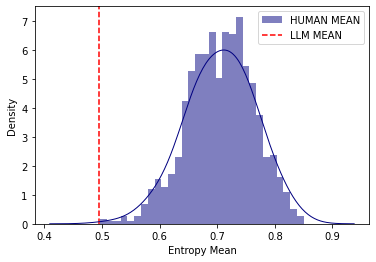

In [54]:
trait = 'C'
plt.hist(mu_bootstrap[trait], bins=30, alpha=0.5, color='navy', density=True, label='HUMAN MEAN')

plt.axvline(x=LLM_ENTROPY_MEAN[trait], color='red', linestyle='dashed', label='LLM MEAN')
p = sum(mu_bootstrap[trait] <= LLM_ENTROPY_MEAN[trait]) / len(mu_bootstrap['C'])
sns.kdeplot(mu_bootstrap[trait], linewidth=1, color='navy', bw_adjust=2)
plt.legend()
plt.xlabel("Entropy Mean")
plt.ylabel("Density")
print(p)

0.0


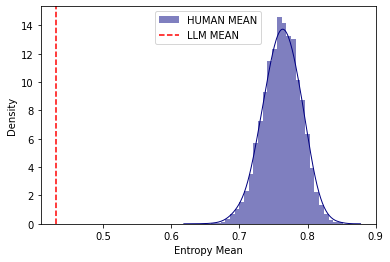

In [23]:
trait = 'N'
plt.hist(mu_bootstrap[trait], bins=30, alpha=0.5, color='navy', density=True, label='HUMAN MEAN')

plt.axvline(x=LLM_ENTROPY_MEAN[trait], color='red', linestyle='dashed', label='LLM MEAN')
p = sum(mu_bootstrap[trait] <= LLM_ENTROPY_MEAN[trait]) / len(mu_bootstrap['C'])
sns.kdeplot(mu_bootstrap[trait], linewidth=1, color='navy', bw_adjust=2)
plt.legend()
plt.xlabel("Entropy Mean")
plt.ylabel("Density")
print(p)

### Human Statistics

In [2]:
# OPT-125M-120
LLM_OBS = {
    'O': np.array([1, 5] * 12),
    'C': np.array([1]* 11 + [5]*13),
    'E': np.array([1]* 18 + [5]*6),
    'A': np.array([1]* 7 + [5]*17),
    'N': np.array([1]* 17 + [5]*7)
}

# OPT-350M-120

LLM_OBS = {
    'O': np.array([2, 4] * 12),
    'C': np.array([2]* 11 + [4]*13),
    'E': np.array([2]* 18 + [4]*6),
    'A': np.array([2]* 7 + [4]*17),
    'N': np.array([2]* 17 + [4]*7)
}
# Observation
OBS = {}

for trait in "OCEAN":
    coi = list(filterfalse(lambda k: item_key_map[k][1] != trait, item_key_map))
    OBS[trait] = np.array(IPIP120_df[coi])

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [156]:
def calculate_scores(llm_obs, human_obs, disable_display=False):
    return np.array([wasserstein_distance(llm_obs, obs) for obs in tqdm(human_obs, disable=disable_display)])

LLM_SCORES = {}
for trait in 'OCEAN':
    LLM_SCORES[trait] = calculate_scores(LLM_OBS[trait], OBS[trait])

100%|██████████| 619150/619150 [00:24<00:00, 24794.54it/s]


In [6]:
def dist_to_obs(dist):
    pass


def obs_to_dist(obs):
    dist = []
    for x in tqdm(obs):
        counter = Counter(x)
        dist.append([counter[i] for i in range(1, 6, 1)])
    return np.array(dist)

## Human Distribution Wasserstein Distance Estimation

In [53]:
N = len(IPIP120_df)
n = 1000

OBS_SCORES = {}
# Choose a set of samples
idx = np.random.choice(N, n, replace=False)
# ic(idx)
for trait in 'OCEAN':
        trait_obs = OBS[trait]
        sample_scores = []
        # For efficiency, we only measure the upper diagonal pairs as Wasserstein distance is symmetric
        for i in tqdm(range(n)):
                # wass_score = []
                for j in range(i, n, 1):
                        sample_scores.append(wasserstein_distance(trait_obs[i], trait_obs[j]))
                # sample_scores.append(wass_score)
        sample_scores = np.array(sample_scores)
        sample_scores_1d = sample_scores.reshape((-1,))
        # Store
        OBS_SCORES[trait] = sample_scores_1d


100%|██████████| 1000/1000 [00:19<00:00, 50.16it/s]


In [154]:
import torch
torch.save(OBS_SCORES, "human/HUMAN_OBS_SCORES.pt")

In [ ]:
# For verification purpose only: this cell may take 20 minutes to rerun
# Pick 10 human, compute their answer distributions with all others
# We expect the distribution to be similar the one estimated by those 1000 samples before
rand_human_idx = np.random.choice(N, 10, replace=False)
HUMAN_VAL_SCORES = {}

for trait in "OCEAN":
    trait_obs = OBS[trait]
    human_val_scores = []
    for human in tqdm(rand_human_idx):
        human_val_scores.append(calculate_scores(trait_obs[human].reshape((-1,)), trait_obs, True))
    HUMAN_VAL_SCORES[trait] = np.array(human_val_scores).reshape((-1,))

In [150]:
import torch
torch.save(HUMAN_VAL_SCORES, "human/HUMAN_VAL.pt")

In [157]:
config = {
    'num_bins': 30,
    'alpha': 0.3,
    # 'c1': '#0000a7',
    'c1': 'navy',
    # 'c2': '#eecc16',

    'c2': '#c1272d',
    # 'c1': '#b3b3b3',
    'trait': 'O',
    'l1': 'Human',
    # 'l2': 'OPT-125M',
    'l2': 'Test',
    # 'l2': 'Human Test',
    # 'l2': 'OPT-13B',
    'title': 'OPT-125M-Human'
}


def plot_distribution(dist1, dist2, c):
    plt.hist(dist1, bins=c['num_bins'], density=True, alpha=c['alpha'], color=c['c1'], label=c['l1'])
    plt.hist(dist2, bins=c['num_bins'], density=True, alpha=c['alpha'], color=c['c2'], label=c['l2'])
    sns.kdeplot(dist1, linewidth=1, color=c['c1'], bw_adjust=2)
    sns.kdeplot(dist2, linewidth=1, color=c['c2'], bw_adjust=2)
    plt.legend()
    plt.xlabel("Wasserstein Distance")
    plt.ylabel("Density")
    plt.title(f"Pairwise Wasserstein Distance Distribution - Trait {c['trait']}")
    plt.savefig(f"human/{c['l1'] + '-' + c['l2']}-{c['trait']}.jpg", dpi=1200)
    plt.close()

for trait in 'OCEAN':
    dist1 = OBS_SCORES[trait]
    # dist2 = HUMAN_VAL_SCORES[trait].reshape((-1,))
    dist2 = LLM_SCORES[trait]
    config['trait'] = trait
    plot_distribution(dist1, dist2, config)

In [152]:
def plot_llm_distribution(dist, c):
    plt.hist(dist, bins=c['num_bins'], density=True, alpha=c['alpha'], color=c['c2'], label=c['l2'])
    sns.kdeplot(dist, linewidth=1, color=c['c2'], bw_adjust=2)
    plt.legend()
    plt.xlabel("Wasserstein Distance")
    plt.ylabel("Density")
    plt.title(f"Pairwise Wasserstein Distance Distribution - Trait {c['trait']}")
    plt.savefig(f"human/{c['l2']}-{c['trait']}.jpg", dpi=1200)
    plt.close()

for trait in 'OCEAN':
    dist = LLM_SCORES[trait]
    config['trait'] = trait
    plot_llm_distribution(dist, config)

In [148]:
def find_percentage_below(scores, threshold):
    mask = scores <= threshold
    num = sum(mask)
    p = num/ len(scores)
    return mask, num, p
for trait in 'OCEAN':
    p_lst = []
    for threshold in [1, 1e-1, 1e-2, 1e-3, 1e-4]:
        mask, num,  p = find_percentage_below(OBS_SCORES[trait], threshold)
        # ic(num)
        # ic(f"{p*100:.4f}%")
        p_lst.append(f"{p*100:.4f}%")
    print(trait)
    print(p_lst)

O
['81.6755%', '0.7730%', '0.2174%', '0.2174%', '0.2174%']
C
['73.3760%', '0.7504%', '0.2176%', '0.2176%', '0.2176%']
E
['72.8923%', '0.6701%', '0.2152%', '0.2152%', '0.2152%']
A
['81.3045%', '0.9293%', '0.2282%', '0.2282%', '0.2282%']
N
['67.6016%', '0.6072%', '0.2142%', '0.2142%', '0.2142%']


Threshold: [1, 0.1, 0.001, 0.0001, 0.00001]
O
['81.6755%', '0.7730%', '0.2174%', '0.2174%', '0.2174%']
C
['73.3760%', '0.7504%', '0.2176%', '0.2176%', '0.2176%']
E
['72.8923%', '0.6701%', '0.2152%', '0.2152%', '0.2152%']
A
['81.3045%', '0.9293%', '0.2282%', '0.2282%', '0.2282%']
N
['67.6016%', '0.6072%', '0.2142%', '0.2142%', '0.2142%']

## Entropy Calculation

In [ ]:
def normalize(arr): return arr / np.sum(arr, axis=1, keepdims=True)
def entropy(arr):
    tmp = arr
    tmp[arr == 0] = 1
    log_arr = np.emath.logn(5, tmp) # 5 classes so log base 5
    return -np.sum(arr * log_arr, axis=1)

In [158]:
LLM_DIST = {}

for trait in 'OCEAN':
    LLM_DIST[trait] = normalize(obs_to_dist(LLM_OBS[trait].reshape((1, -1))))

LLM_ENTROPY = {}
for trait in 'OCEAN':
    LLM_ENTROPY[trait] = entropy(LLM_DIST[trait])

onehot = np.array([[1, 0, 0, 0, 0]])
uniform = np.array([[0.2, 0.2, 0.2, 0.20, 0.20]])
ic(entropy(onehot))
ic(entropy(uniform))
LLM_ENTROPY

100%|██████████| 1/1 [00:00<00:00, 10305.42it/s]
ic| entropy(onehot): array([-0.])
ic| entropy(uniform): array([1.])


{'O': array([0.43067656]),
 'C': array([0.42851664]),
 'E': array([0.34939847]),
 'A': array([0.37506091]),
 'N': array([0.37506091])}

In [124]:
HUMAN_DIST = {}
for trait in 'OCEAN':
    HUMAN_DIST[trait] = normalize(obs_to_dist(OBS[trait]))

HUMAN_ENTROPY = {}
for trait in 'OCEAN':
    HUMAN_ENTROPY[trait] = entropy(HUMAN_DIST[trait])

100%|██████████| 619150/619150 [00:06<00:00, 92595.75it/s] 


In [125]:
ic(HUMAN_DIST['O'].shape)
ic(HUMAN_ENTROPY['O'].shape)
HUMAN_ENTROPY['O']

ic| HUMAN_DIST['O'].shape: (619150, 5)
ic| HUMAN_ENTROPY['O'].shape: (619150,)


array([0.70391133, 0.68665388, 0.83942405, ..., 0.73079042, 0.87710584,
       0.76689374])

In [145]:
config = {
    'num_bins': 30,
    'alpha': 0.3,
    'c1': 'navy',
    # 'c2': '#eecc16',
    'c2': '#c1272d',
    'trait': 'O',
    'l1': 'Human',
    'l2': 'OPT-125M',
    'title': 'OPT-125M-Human'
}


def plot_entropy(dist, llm_entropy, c):
    plt.hist(dist, bins=c['num_bins'], density=True, alpha=c['alpha'], color=c['c1'], label=c['l1'])
    plt.axvline(x=llm_entropy, color=c['c2'], linestyle='dashed', label=c['l2'])
    sns.kdeplot(dist, linewidth=1, color=c['c1'], bw_adjust=2)
    plt.legend()
    plt.xlabel("Entropy")
    plt.ylabel("Density")
    plt.title(f"Entropy Distribution - Trait {c['trait']}")
    plt.savefig(f"human/Entropy-{c['l1'] + '-' + c['l2']}-{c['trait']}.jpg", dpi=1000)
    plt.close()

for trait in 'OCEAN':
    dist = HUMAN_ENTROPY[trait]
    llm_entropy = LLM_ENTROPY[trait]
    config['trait'] = trait
    plot_entropy(dist, llm_entropy, config)